# Case 7: Data cleaning/wrangling

## *How do we prepare data for use with an analytics platform?*

In [1]:
import base64
import datetime
import json
import os
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim

## Goals (3 min)

In this case, we will introduce an uncleaned dataset - the type of dataset that you will most likely be working with in a job setting. We hope to provide you with a framework for tackling some common problems of unclean datasets (missing values, typos, etc.) as well as get you accustomed to integrating the Jupyter environment with other data environments (namely, AWS).

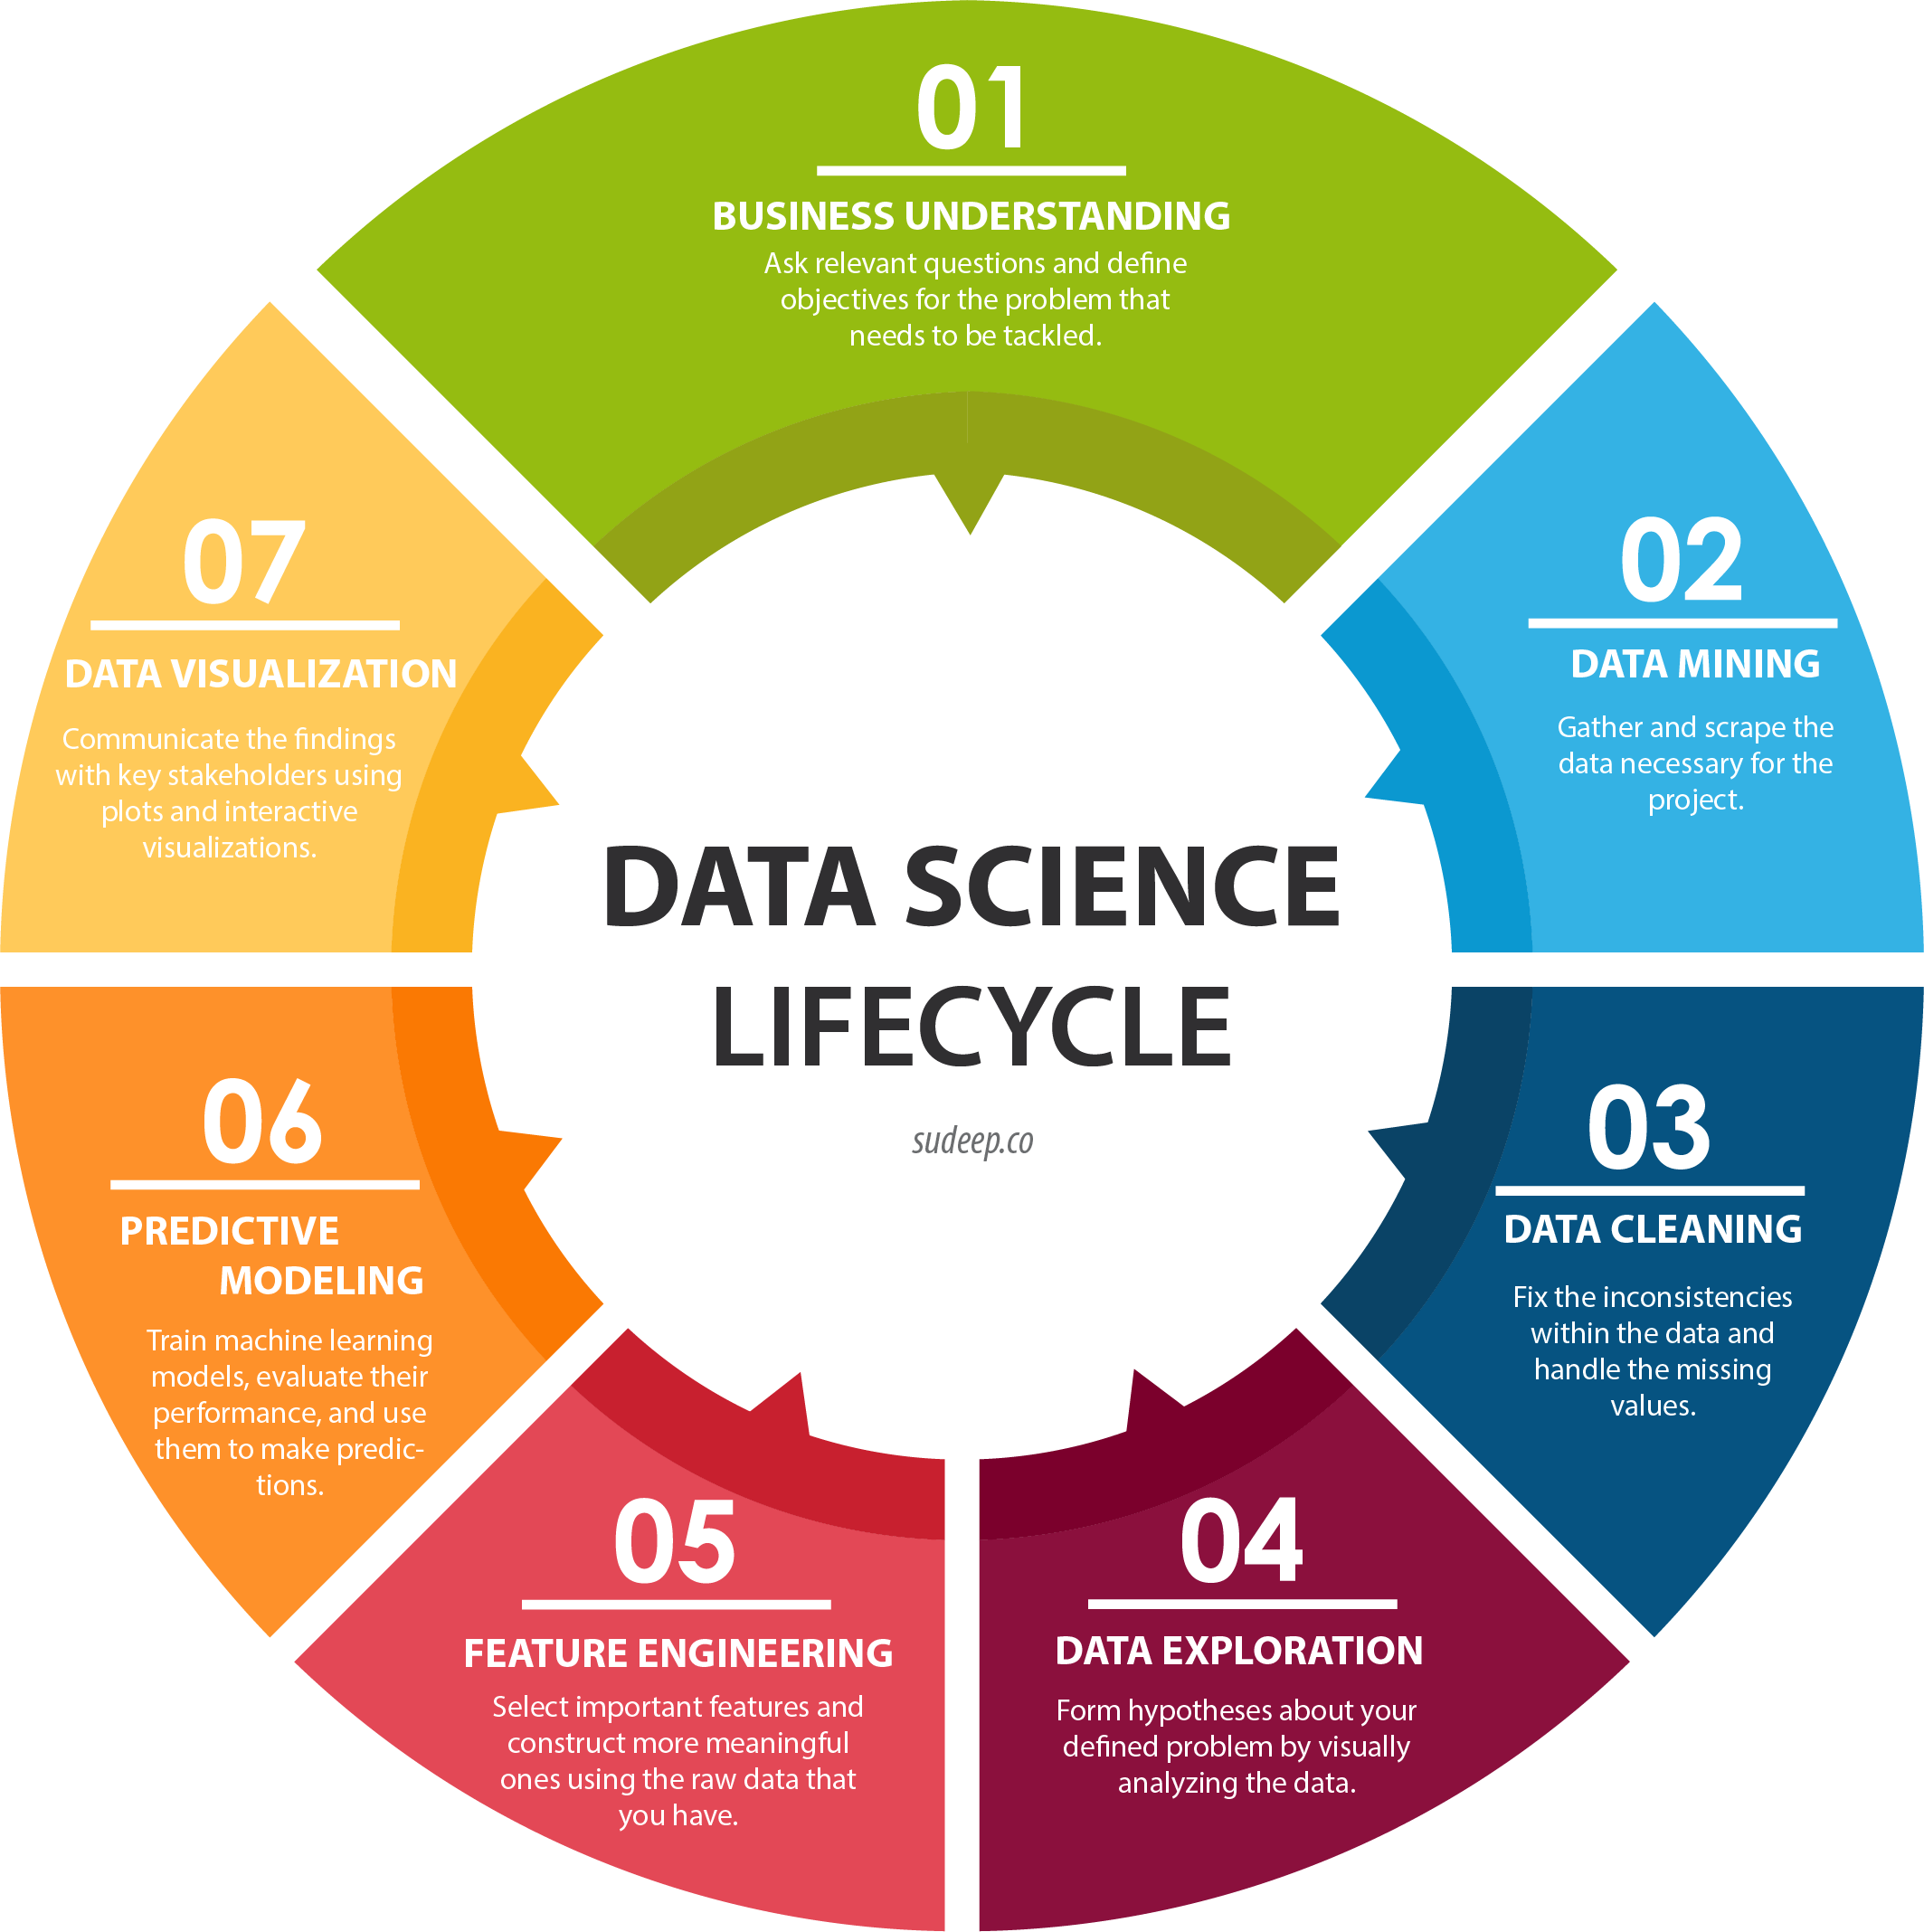

In [2]:
from IPython.display import Image
Image("http://www.cortell.co.za/wp-content/uploads/2018/06/chart.png",width=600)

## Introduction (5 min)

**Business Context.** You are a data science consultant for a bike share company. The company has hundreds of thousands of users and has been collecting data about trips taken on each of their bikes. Since the dataset collected is quite large and increasing by the day, they have subscribed to a new analytics platform which gives them information and insights when they feed trip data into it. However, the analytics platform requires the collected data to be cleaned and converted into a certain format, for which the client requires your help.

**Business Problem.** Your task is to transform the raw data the client has into a format that can be fed into their analytics platform, as well as add additional features that the client wants to see in their platform, which are mentioned below.

**Analytical Context.** The data provided by the client is spread across 2 files. The first file is a CSV file that contains all the trip data, with features such as trip time, start and end stations, bike number, and the user details like whether it is a registered or a casual user, etc. The second file is a JSON file containing details about the stations they own. In addition to cleaning their existing data, the client wants you to add the following features:

1. Generate a unique ID for each trip
2. For each trip, calculate its duration, and based on this generate 4 more columns: `start_hour`, `end_hour`, `start_weekday`, `end_weekday`
3. For each trip, create new columns for  age of the user, start and end coordinates, and municipal/city details of the start and end stations

In this case, you will: (1) Get data that was extracted from Amazon S3 and take a subset for local use (because the dataset is quite large); (2) use common sense to judge likely use cases of the data and clean it; (3) add new features to the data based on client request; and finally (4) leave the message that you should upload the data wrangling scripts Jupyter Notebook to Amazon EC2 so we can apply it to the entire dataset.

## Fetch data from S3

The data files are provided to you via an Amazon S3 bucket. For the purpose of this course data is in an CSV format.

## Exploring the data (5 min)

The data is now copied to the local folder. Let's read the data using the [read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) method.

It is important to be more careful and diligent in the initial EDA stages when working with unclean data since good EDA is often essential for finding the tiny clues that inform you of the proper changes to make to unclean data. A common example would be a repetitive typo, such as 1% of the rows have "New York" spelled as "New Yok". We can use a combination of `groupby()` and `count()` in order to get a summary of the different values in a particular column, and notice that there are some common misspelled proper nouns.

Furthermore, it can also be a good habit to shuffle the data and sift through a few hundred/thousand rows manually to get a good "feel" for the data. While this may seem excessive, you make catch an insight that will dramatically accelerate your data science process and that is definitely worth the extra time and effort. Learn to love manually digging into the data if you want to be a data professional.
    
Note that we are passing a parameter `nrows=10000` so that we only read in the first 10000 rows in the file (as mentioned earlier, we are working with a subset of the data on our local machine as the entire dataset is quite large):

In [3]:
local_folder = '.'
# Read the data file and take a look at the data
df = pd.read_csv(os.path.join(local_folder, 'trips.csv'))

df.head()

,status,start_date,start_station,end_date,end_station,bike_nr,subsc_type,zip_code,birth_date,gender
0,Closed,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,Closed,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,Closed,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,Closed,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,Closed,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female


As discussed before, the first step we ought to take with a new dataset is to familiarize ourselves with it. Let's read through the columns present in the dataset, find out how the data is spread out across columns, etc. This will also give us a sense of the obvious cleaning steps to be performed on each column present in the dataset.

In [4]:
# Take a look at the columns present
df.columns

Index(['status', 'start_date', 'start_station', 'end_date', 'end_station',
       'bike_nr', 'subsc_type', 'zip_code', 'birth_date', 'gender'],
      dtype='object')

The list of available features is as follow:

1. **status:** Status of the trip ("Ongoing", "Closed")
2. **start_date:** Start time of the trip
3. **start_station:** id of the station from which this trip started
4. **end_date:** End time of the trip
5. **end_station:** id of the station from which this trip ended
6. **bike_nr:** The unique identifier of the bike used in this trip
7. **subsc_type:** Subscription type of the user ("Registered", "Casual")
8. **zip_code:** If it is a registered user, their zipcode
9. **birth_date** If it is a registered user, their date of birth
10. **gender** If it is a registered user, their gender ("Male", "Female")

## Handling null values (20 min)

Let's start with the data cleaning process. As discussed in the intro Python cases, one of the first steps is to deal with null or missing values. However, previous cases only gave a passing treatment of these and resulted in dropping the rows containing null values entirely. Here, we will be more nuanced and look at ways that null or missing values can be replaced with more understandable and logical values. 

In the real world, dealing with null values definitely has an artistic component, and you may have to test methods to see what works best. As always, domain knowledge is crucial in selecting what method to go forward with. For this program, we will introduce some of the simpler and more intuitive approaches, but recommend students to be as creative as they can when resolving null values while still adhering to logic.

**1. The goal of filling in missing data is to not discover the missing data but rather to make sure we get similar results as if we had complete data.**

**2. Find the source of the missing data. Why is it missing?**

**3. Don't use generic pandas/python functions without thinking.**


Generally, null values in a specific column are dealt with in one of the following ways:

1. Any row containing a null value for that column is removed
2. If that column's feature is a string, null values are replaced with a "Not found" string. If that column's feature is a number, null values are replaced either with 0 or the mean/median of the available values in the column
3. Null values are replaced with an interpolated value based on the data present in other rows

Let's start by taking a look at the list of columns that have null values:

In [5]:
df.isnull().any()

status           False
start_date       False
start_station    False
end_date         False
end_station       True
bike_nr           True
subsc_type       False
zip_code          True
birth_date        True
gender            True
dtype: bool

We can see that there are 5 columns that have null values. We need to decide, based on the importance of each column, whether we will be applying a blunt instrument and remove the rows that have a particular column as null, or if we will be more nuanced and replace the null values in that column with a replacement value.

### Exercise 1: (5 min)

`bike_nr` is one of the columns with missing values. Which of the above three methods do you think is most appropriate?

**Answer.** We can first see that method 3 is not sensible. This is because `bike_nr` is assigned before any trips are taken with that bike; hence, every other feature of the dataset is necessarily generated after the bike number is assigned. This means that there is no rhyme or reason for what `bike_nr` should be based on the other columns (because its creation preceded all the others), so there is no reason to expect a reasonable value to result from interpolation.

Given that at best we can only fill `bike_nr` with a meaningless filler value, it may be tempting to remove rows without `bike_nr` entirely. However, removing a row entirely tends to be the nuclear option and in the absence of a very clear and limited use case for the dataset going forward, it may result in us regretting our choice once we realize that some data we cut out might actually be useful. For example, if in some future analyses the client cares a fair amount about aggregate statistics relating to many or all the trips, then a specific `bike_nr` value is not important and we can still get useful analysis by replacing each `bike_nr` with a "Not Found", whereas we could well be missing that analysis if we cut out too much data. Thus, option 2 is the best answer.

Based on the above, let's now replace null values for `bike_nr` with "Not found":

In [6]:
df['bike_nr'].fillna('Not Found', inplace=True)

The next column we can concentrate on is `gender`. We know that `gender` can have only one of the 2 values: "Male" or "Female".

### Exercise 2: (5 min)

Suppose that one thing (but not the only thing) our client cares about is a rough idea of how the number of male and female riders has changed over time. Which of the above three methods would be most appropriate?

**Answer.** Again, removing rows entirely is the nuclear option, and there is no reason to do so without a very clear and limited objective for this dataset. Now, we may be tempted to fill in the missing values with "Not found". However, what if the missing data is disproportionately concentrated in later dates? Then later on, when the client tries to use their software to plot this trend, they will get a growth rate result that is far too low compared to real life. Thus, the best option is to fill in the missing data using some interpolation method to preserve the integrity of the growth rate data.

Now, how do we go about doing this? Well, we can use the [interpolate()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html) function in `pandas`. The `interpolate()` function uses linear interpolation, which is a mathematical method for filling in unknown points based on building a linear regression model on the non-missing points. We can then use this model to estimate the values of the missing points. This is very different from substituting null values with random or meaningless values, as it preserves aspects of the distribution of the data, which can be very important for certain analyses.

But gender is a string; how can we apply a mathematical model to a string? Well luckily, gender can only take on two values, so we can convert it to a `category` type and then run the interpolation:

In [7]:
# Convert gender to a category type
df['gender'] = df['gender'].astype('category')

After converting `gender` to be a category column, let's see what the data looks like:

In [8]:
df['gender'].cat.categories

Index(['Female', 'Male'], dtype='object')

In [9]:
# Let's see the codes assigned to the values present in the DataFrame.
df['gender'].cat.codes

0       1
1       1
2       1
3       0
4       0
       ..
9995   -1
9996   -1
9997   -1
9998   -1
9999   -1
Length: 10000, dtype: int8

You can see there are 3 codes here: -1, 0, 1. But in the categories list, there are only 2 values: "Male" and "Female". This is because -1 represents the NaN values. In order to interpolate the values, we need to convert the -1 into actual NaN, as interpolation works only on NaN values:

In [10]:
# The below code replaces the value -1 with NaN.
gender = df['gender'].cat.codes.replace(-1, np.nan)
gender

0       1.0
1       1.0
2       1.0
3       0.0
4       0.0
       ... 
9995    NaN
9996    NaN
9997    NaN
9998    NaN
9999    NaN
Length: 10000, dtype: float64

In [11]:
# We now call the interpolate function that actually fills the NaN values with either a 0 or 1
gender = gender.interpolate()

In [12]:
gender = gender.astype(int).astype('category')
gender = gender.cat.rename_categories(df['gender'].cat.categories)
df['gender'] = gender
df['gender']

0         Male
1         Male
2         Male
3       Female
4       Female
         ...  
9995      Male
9996      Male
9997      Male
9998      Male
9999      Male
Name: gender, Length: 10000, dtype: category
Categories (2, object): ['Female', 'Male']

In the above snippet, we are converting the interpolated values into category type and then replacing the category names with the names from the existing DataFrame column. So now the gender column will contain "Male" and "Female" as its values (rather than 0 and 1).

### Exercise 3: (5 min)

Come up with a proper replacement scheme for null values in `zip_code`, `birth_date`, and `end_station`.

**Answer.** Let's start with `zip_code`. Again, removing rows is a nuclear option and we should avoid it unless we have a very clear and limited objective for the dataset. So we can either replace zip code with a meaningless filler value, or attempt to interpolate it. However, we have no other features in this dataset that can sufficiently narrow down the bike rider's/user's zip code in any significant way. Therefore, any interpolation attempt would involve a lot of hand-wavey guessing. Thus, we will go ahead and replace null `zip_code` values with a meaningness filler value. Since zip codes are effectively strings (they are numbers, but they have no natural ordering; i.e. the fact that one zip code number is larger than another is meaningless), we will replace null values with "Not found".

The same line of reasoning leads us to fill in "Not found" for missing values in the `end_station` column.

For `birth_date`, a similar line of reasoning as above tells us we should fill it with a meaningless filler value as well. Now, because `birth_date` contains only the year of birth, it can be considered to be a numeric field. So we default the null `birth_date` values to 0:

In [13]:
df['zip_code'].fillna('Not found', inplace=True)
df['zip_code']
df['end_station'].fillna('Not found', inplace=True)
df['end_station']
df['birth_date'].fillna(0, inplace=True)
df['birth_date']

0       1976.0
1       1966.0
2       1943.0
3       1981.0
4       1983.0
         ...  
9995       0.0
9996       0.0
9997       0.0
9998       0.0
9999       0.0
Name: birth_date, Length: 10000, dtype: float64

Did you notice the `inplace=True` parameter passed to the [fillna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) function? By passing this parameter we are asking `pandas` to make the changes in memory, instead of creating a new object that contains the result of this operation. The above statement is technically the equivalent of:

```
    df['gender'] = df['gender'].fillna('No Gender')
```

## Correcting erroneous string values (10 min)

After cleaning the null values in the dataset, the next process we usually do is to check for and deal with erroneous values in the dataset. For string columns, this can manifest in a few ways:

1. Unnecessary spaces at the start or end of the string
2. Mixed case (e.g. "value 1" and "Value 1")
3. Spelling mistakes

However, this can be quite difficult to clean for in practice. In particular, number 3 (spelling mistakes) are nearly impossible to find if that string column is meant to be free-form; any legitimate English word would be a legal entry, and you would have to cross-check each entry against the entire English dictionary! Situations like this are why sometimes a manual sifting of thousands of rows can be beneficial. It is a lot easier for the naked eye to catch and error and then write code for systematically cleaning up that type of error from the entire dataset, than to guess at what type of error even exists and writing code for that unsubstantiated guess.

Luckily, certain types of string columns are far easier to deal with. For example, `subscription_type`, `gender` and `status` are categorical; i.e. their values are supposed to come from a defined set of options. This means that we can do some basic data summarizing to see whether they contain any values they are not supposed to:

In [14]:
print("Subscription Type: ", df['subsc_type'].unique())
print("Gender:", df['gender'].unique())
print("Status:", df['status'].unique())

Subscription Type:  ['Registered' 'Casual' 'registered' ' Casual' 'Casual ' 'casual'
 ' Registered']
Gender: ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
Status: ['Closed']


The data shows that `gender` and `status` only have 2 values, as expected.

However, in the `subscription_type` column, you will see that there are 3 `Regular`s and 3 `Casual`s. This is because of leading and trailing spaces. You can also see that this column has `regular` and `casual` as values. Though `Regular` and `regular` are same, they are identified as 2 different values because of their mixed case.

Let's go ahead and fix both of these issues:

In [15]:
# Let's fix the space issue. We will use the strip function to remove the leading and trailing spaces 
# for each row in the subsc_type column
df['subsc_type'] = df['subsc_type'].str.strip()

df['subsc_type'].unique()

array(['Registered', 'Casual', 'registered', 'casual'], dtype=object)

In [16]:
df['subsc_type'] = df['subsc_type'].str.upper()

df['subsc_type'].unique()

# We have cleansed both the gender and subscription type columns to contain proper values.

array(['REGISTERED', 'CASUAL'], dtype=object)

In practice, data scientists will apply the [strip()](https://www.w3schools.com/python/ref_string_strip.asp) and [upper()](https://www.w3schools.com/python/ref_string_upper.asp) (or [lower()](https://www.w3schools.com/python/ref_string_lower.asp), either is fine) functions even to free-form, non-categorical string columns to avoid any unintentional duplicates (though as mentioned earlier, spelling mistakes need to be dealt with separately). An example of this is if you had a column specifying the city someone was from – you would not want "New York City, New York" to be treated differently from "new york city, New York".

There are many ways that values within a column can be erroneous, and we have only covered a few of them here. In future cases, you will learn about other ways erroneous values can creep into your dataset (say, in numeric or `datetime` columns) and how to deal with them. For now, let's move on.

## Generating a unique ID for each trip (10 min)

Let's get going on the specifics that the client wants. The first request relates to unique identifiers. When generating unique identifiers for datasets like this, we should make sure the generation process is idempotent (i.e. the same ID should be generated for each trip no matter how many times you run the script). The idempotency is required because there may be chances that the same trip is input into this tool multiple times. For example, the customer first uploads the data set for the first week of the month (may be for testing purposes, or based on data availability, etc.) and then uploads the data for the entire month. Now if the same trip is assigned different IDs on each run, then it might result in the analytics platform interpreting this as two different trips and this will skew the analysis.

ID generation is a subset of **feature engineering** which we will cover in greater detail in future cases. Here, we just want to introduce you to the idea of combining/manipulating various parameters to create new ones that may greatly help you solve your data science problem.

### Exercise 4: (5 min)

Describe how you would generate a unique ID per trip while guaranteeing idempotence, then write code to do this.

**Answer.** Before it gets assigned an ID, a trip can only be uniquely identified via a suitable combination of its features. We reason that `start date`, `end date`, and `bike_nr` will always be unique, because any given bike can only be taking one trip at a time. Therefore, we will define a one-to-one function of these three quantities to generate the unique ID. (A one-to-one function is one such that for any given output, there can only be one possible input that generates that output.)

Now let's go ahead and write code for this:

In [17]:
# Let's generate an id for each trip, in order to uniquely identify each trip. 
# The trip id can be a combination of start_date, end_date, start_station, end_station and bike number
df['id'] = df.apply(lambda x: ':'.join([str(x['start_date']), str(x['end_date']), str(x['bike_nr'])]), axis=1)

# In order for the id to look actually like a unique identifier, let's use base64 encode to convert the id to a base64 string
# The command converts the newly created id column into bytes, and then gets the base64 encoded value for the same. 
# Then the base64 value is converted to string again and then stored in the id column.
df['id'] = df['id'].apply(lambda x: base64.b64encode(x.encode()).decode())

df['id'].unique()

array(['Ny8yOC8yMDExIDEwOjEyOjAwOjcvMjgvMjAxMSAxMDoxMjowMDpCMDA0Njg=',
       'Ny8yOC8yMDExIDEwOjIxOjAwOjcvMjgvMjAxMSAxMDoyNTowMDpCMDA1NTQ=',
       'Ny8yOC8yMDExIDEwOjMzOjAwOjcvMjgvMjAxMSAxMDozNDowMDpCMDA0NTY=',
       ..., 'OC83LzIwMTEgMjA6NDI6MDA6OC83LzIwMTEgMjA6NTk6MDA6QjAwMTUx',
       'OC83LzIwMTEgMjA6NDI6MDA6OC83LzIwMTEgMjA6NTg6MDA6QjAwMDk0',
       'OC83LzIwMTEgMjA6NDQ6MDA6OC83LzIwMTEgMjE6MTc6MDA6QjAwMTcw'],
      dtype=object)

## Trip timing details (15 min)

The second requirement of your client is to create a few additional features. These are also a subset of feature engineering. The first of these is trip duration. Now, trip duration is defined as `end time - start time`, so naturally we would consider using those columns. But if you take a look at the start and end date columns, you can see that they are not listed as `datetime` columns; rather, they are just shown as strings. In order to calculate the trip duration, we will have to convert the strings into [datetime](https://www.w3schools.com/python/python_datetime.asp) objects. We will be using the [pd.to_datetime()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) function to convert all values of a column into date objects:

In [18]:
# Then with the remaining values, convert them to datetime objects
df['start_date'] = pd.to_datetime(df['start_date'], format='%m/%d/%Y %H:%M:%S')
df['end_date'] = pd.to_datetime(df['end_date'], format='%m/%d/%Y %H:%M:%S')

# You can now see that the start date and end date are converted to datetime objects.
df[['start_date', 'end_date']]

,start_date,end_date
0,2011-07-28 10:12:00,2011-07-28 10:12:00
1,2011-07-28 10:21:00,2011-07-28 10:25:00
2,2011-07-28 10:33:00,2011-07-28 10:34:00
3,2011-07-28 10:35:00,2011-07-28 10:36:00
4,2011-07-28 10:37:00,2011-07-28 10:37:00
...,...,...
9995,2011-08-07 20:38:00,2011-08-07 21:04:00
9996,2011-08-07 20:38:00,2011-08-07 21:04:00
9997,2011-08-07 20:42:00,2011-08-07 20:59:00
9998,2011-08-07 20:42:00,2011-08-07 20:58:00


With start date and end date being datetime objects now, it is easy to calculate the trip duration for each trip.

In [19]:
df['trip_duration'] = (df['end_date'] - df['start_date'])

df['trip_duration'] = df['trip_duration'].apply(lambda x: x.seconds)

In [20]:
# trip_duration column will contain the duration of the trip in seconds
df['trip_duration']

0          0
1        240
2         60
3         60
4          0
        ... 
9995    1560
9996    1560
9997    1020
9998     960
9999    1980
Name: trip_duration, Length: 10000, dtype: int64

### Exercise 5: (5 min)

Generate the 4 other time-related columns the client wants: `start_weekday`, `start_hour`, `end_weekday`, `end_hour`.

**Answer.** One possible solution is given below:

In [21]:
df['start_hour'] = df['start_date'].dt.hour
df['end_hour'] = df['end_date'].dt.hour
df['start_weekday'] = df['start_date'].dt.weekday
df['end_weekday'] = df['end_date'].dt.weekday

In [22]:
df.head()

,status,start_date,start_station,end_date,end_station,bike_nr,subsc_type,zip_code,birth_date,gender,id,trip_duration,start_hour,end_hour,start_weekday,end_weekday
0,Closed,2011-07-28 10:12:00,23.0,2011-07-28 10:12:00,23.0,B00468,REGISTERED,'97217,1976.0,Male,Ny8yOC8yMDExIDEwOjEyOjAwOjcvMjgvMjAxMSAxMDoxMj...,0,10,10,3,3
1,Closed,2011-07-28 10:21:00,23.0,2011-07-28 10:25:00,23.0,B00554,REGISTERED,'02215,1966.0,Male,Ny8yOC8yMDExIDEwOjIxOjAwOjcvMjgvMjAxMSAxMDoyNT...,240,10,10,3,3
2,Closed,2011-07-28 10:33:00,23.0,2011-07-28 10:34:00,23.0,B00456,REGISTERED,'02108,1943.0,Male,Ny8yOC8yMDExIDEwOjMzOjAwOjcvMjgvMjAxMSAxMDozND...,60,10,10,3,3
3,Closed,2011-07-28 10:35:00,23.0,2011-07-28 10:36:00,23.0,B00554,REGISTERED,'02116,1981.0,Female,Ny8yOC8yMDExIDEwOjM1OjAwOjcvMjgvMjAxMSAxMDozNj...,60,10,10,3,3
4,Closed,2011-07-28 10:37:00,23.0,2011-07-28 10:37:00,23.0,B00554,REGISTERED,'97214,1983.0,Female,Ny8yOC8yMDExIDEwOjM3OjAwOjcvMjgvMjAxMSAxMDozNz...,0,10,10,3,3


### Exercise 6: (5 min)

Replicate the process we used to calculate trip duration in order to calculate the age of the registered users.

**Answer.** One possible solution is given below:

In [21]:
dob_users = df[df['birth_date'].notnull()]
current_year = datetime.datetime.now().year
df.loc[df['birth_date'].notnull(), 'age'] = current_year - dob_users['birth_date'] 

df['age']

0         45.0
1         55.0
2         78.0
3         40.0
4         38.0
         ...  
9995    2021.0
9996    2021.0
9997    2021.0
9998    2021.0
9999    2021.0
Name: age, Length: 10000, dtype: float64

## Adding stations data (15 min)

The last thing we need to do is add municipal details as well as coordinates of the start and end stations. To get the latitude and longitude of each station, we will be using the address of the stations present in the [JSON](https://www.w3schools.com/js/js_json_intro.asp) file provided along with the CSV data.

Notice that we are combining information from different files (and also different file types) to progress in our investigation of this dataset. This is extremely common and in the professional world you may have to utilize different files from very different sources with varying degrees of reliability/accuracy to solve problems. You may have to clean these accessory datasets beforehand just to make them usable. In fact, most data professionals spend much more time on cleaning data than on modeling.

The JSON file contains the station ID, station name, and municipal. We will generate the address by concatenating the station and municipal fields and then use the `Nominatim`, which is a geocoding library provided and maintained by OpenStreetMap:

In [24]:
# With the trip data in place, next we can pull the JSON data of the stations.
stations_data = []
with open(os.path.join(local_folder, 'stations.json')) as f:
    stations_data = json.load(f)

In [26]:
# For each of the stations, let's get the latitude and longitude for each of the stations, based on the address
geolocator = Nominatim(user_agent="Address Predictor", timeout=10)
for station in stations_data:
    address = station['station'] + ',' +  station['municipal']
    print(address)
    lat_long = geolocator.geocode(address)
    if lat_long:
        print(lat_longlatitude)
        location = ','.join([str(lat_long.latitude), str(lat_long.longitude)])
    else:
        location = 'None,None'
    station['coordinates'] = location

Colleges of the Fenway,Boston
42.3400317
 Berkeley St.,Boston
42.3530442
Northeastern U ,Boston
46.5113444
 Joy St.,Boston
42.3604299
Fan Pier,Boston
42.354657599999996
Union Square ,Boston
42.3537285
Agganis Arena ,Boston
42.3522233
B.U. Central ,Boston
Longwood Ave ,Boston
42.3364326
ion ,Boston
46.7402161
Boston Medical Center ,Boston
42.33417195
HMS ,Boston
42.337171
e ,Boston
39.8881269
Back Bay ,Boston
42.35054885
Harvard University Housing ,Boston
42.3644647
e ,Boston
39.8881269
Buswell Park,Boston
42.347241
ion ,Boston
46.7402161
Prudential Center ,Boston
42.34709075
ion ,Boston
46.7402161
Mayor Thomas M. Menino ,Boston
42.3780804
Seaport Square ,Boston
42.348829949999995
Tremont St ,Boston
42.3517219
 Waltham St.,Boston
42.342256
ion,Boston
46.7402161
ion Lab ,Boston
Brigham Cir ,Boston
42.3346084
Seaport Hotel,Boston
42.3491401
Landmark Centre,Boston
42.343912
Kenmore Sq ,Boston
42.3489517
 Brookline Ave,Boston
42.3356437
Summer St. ,Boston
42.3392189
Boston Public Library ,B

### Exercise 7: (10 min)

`stations_data` now contains the coordinates for each station. Use this to add the start and end coordinates to each trip in the trips data. Add the municipal data for each trip as well.

**Answer.** One possible solution is given below:

In [24]:
# Let's create a dictionary with the id of the station as key, to be able to get the station details for each row
stations_dict = {}
for station in stations_data:
    stations_dict[station['id']] = station
    
stations_dict

{3: {'id': 3,
  'terminal': 'B32006',
  'station': 'Colleges of the Fenway',
  'municipal': 'Boston',
  'status': 'Existing',
  'coordinates': '42.3400317,-71.1008718'},
 4: {'id': 4,
  'terminal': 'C32000',
  'station': ' Berkeley St.',
  'municipal': 'Boston',
  'status': 'Existing',
  'coordinates': '42.3530442,-71.0739318'},
 5: {'id': 5,
  'terminal': 'B32012',
  'station': 'Northeastern U ',
  'municipal': 'Boston',
  'status': 'Existing',
  'coordinates': '42.3390301,-71.08791294953176'},
 6: {'id': 6,
  'terminal': 'D32000',
  'station': ' Joy St.',
  'municipal': 'Boston',
  'status': 'Existing',
  'coordinates': '42.3576896,-71.0650893'},
 7: {'id': 7,
  'terminal': 'A32000',
  'station': 'Fan Pier',
  'municipal': 'Boston',
  'status': 'Existing',
  'coordinates': '42.3526115,-71.0440708693832'},
 8: {'id': 8,
  'terminal': 'A32001',
  'station': 'Union Square ',
  'municipal': 'Boston',
  'status': 'Existing',
  'coordinates': '42.3537768,-71.13661996477273'},
 9: {'id': 9,

In [25]:
# We can now get the starting coordinates and ending coordinates for each trip into this DataFrame.
df['start_coordinates'] = df['start_station'].map(lambda x: stations_dict[x]['coordinates'] if x != 'Not found' else None)
df['end_coordinates'] = df['end_station'].map(lambda x: stations_dict[x]['coordinates'] if x != 'Not found' else None)

df[['start_coordinates', 'end_coordinates']]

,start_coordinates,end_coordinates
0,"42.3780804,-71.04848834660194","42.3780804,-71.04848834660194"
1,"42.3780804,-71.04848834660194","42.3780804,-71.04848834660194"
2,"42.3780804,-71.04848834660194","42.3780804,-71.04848834660194"
3,"42.3780804,-71.04848834660194","42.3780804,-71.04848834660194"
4,"42.3780804,-71.04848834660194","42.3780804,-71.04848834660194"
...,...,...
9995,"42.3564297,-71.05571941398325","42.3636368,-71.0508928"
9996,"42.3564297,-71.05571941398325","42.3636368,-71.0508928"
9997,"42.35054885,-71.08031131584724","42.3479022,-71.0752882"
9998,"42.35054885,-71.08031131584724","42.3479022,-71.0752882"


In [26]:
df['start_municipal'] = df['start_station'].map(lambda x: stations_dict[x]['municipal'] if x != 'Not found' else None)
df['end_municipal'] = df['end_station'].map(lambda x: stations_dict[x]['municipal'] if x != 'Not found' else None)

df['end_municipal'].describe()

count       9998
unique         1
top       Boston
freq        9998
Name: end_municipal, dtype: object

## Split the coordinates into separate latitude and longitude columns (5 min)

We have calculated `start_coordinates` and `end_coordinates` for each trip, but they are currently residing in the same column separated by a comma. The client has asked for them to be in separate columns. This can also be viewed as a subset of feature engineering as we are creating new parameters from a single parameter. This is less common than the feature generation example we showed earlier, but it is still relevant.

In [27]:
# Notice the expand=True parameter. That is required since we are assigning the output of the split function to 2 columns
df[['start_latitude', 'start_longitude']] = df['start_coordinates'].str.split(',', expand=True)
df[['end_latitude', 'end_longitude']] = df['end_coordinates'].str.split(',', expand=True)
df[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']]

,start_latitude,start_longitude,end_latitude,end_longitude
0,42.3780804,-71.04848834660194,42.3780804,-71.04848834660194
1,42.3780804,-71.04848834660194,42.3780804,-71.04848834660194
2,42.3780804,-71.04848834660194,42.3780804,-71.04848834660194
3,42.3780804,-71.04848834660194,42.3780804,-71.04848834660194
4,42.3780804,-71.04848834660194,42.3780804,-71.04848834660194
...,...,...,...,...
9995,42.3564297,-71.05571941398325,42.3636368,-71.0508928
9996,42.3564297,-71.05571941398325,42.3636368,-71.0508928
9997,42.35054885,-71.08031131584724,42.3479022,-71.0752882
9998,42.35054885,-71.08031131584724,42.3479022,-71.0752882


## Execute on the entire dataset in a server

In the future you should learn how to access the Jupyter Notebook from the cloud (using AWS, Azure, GCP, etc) and just remove the `nrows=10000` parameter from the `read_csv` function call, in order to read the entire dataset. 

## Conclusions (5 min)

In this case, we cleaned up some messy client data and also added some new features based on their requests. We first took a small sample of the overall data so we could work with it locally. However, cleaning up the data was not merely some rote mechanical work. We had to use our common sense and judgment of likely use cases of this data in order to determine how to fix it. Additionally, we had to consider the potential impact of our changes and whether it would adversely impact potential uses of the data in the future, even if those were not likely uses at this time.

Data wrangling & cleaning is arguably the most important step of the entire data science process, without which we could have wrong or corrupt results. In practice, data scientists can spend upwards of 60 - 70% of their time on cleaning and organizing the data.

## Takeaways (5 min)

When cleaning data, one very common problem is missing data. We learned a few ways of dealing with missing data and when these methods tend to be appropriate:

1. Removing the rows with missing data entirely is a nuclear option that only makes sense when you have a clear and very limited use case for the dataset.
2. Replacing the missing values with a meaningless filler like "Not found" or 0 makes sense if you need to preserve the other data in those rows but either cannot sensibly fill in or don't particularly care about the missing values in that specific column.
3. Interpolating the missing values makes sense when you need to preserve elements of the underlying distribution of the data in that column.

We also saw that for large datasets, working with a small subset of the data is a useful tool for gaining intuition about the dataset and rapidly iterating on the cleaning process. This intuition gathering element cannot be emphasized enough; in fact, many steps in our cleaning process involved elements of exploratory data analysis, via generating summary statistics. Running cleaning steps on the entirety of a very large dataset is time consuming and can bog down the EDA that is essential to cleaning. In future cases, you will see further evidence of EDA in action during wrangling & cleaning.